# CORRECTION SEANCE 5 : recherche de corrélation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('winequality-red.csv',sep=";")
A = df["volatile acidity"]
sA = pd.Series(A,name="volatile acidity")
sA




In [ ]:
B = df["quality"]
sB = pd.Series(B,name="quality")
sB

,quality
0,5
1,5
2,5
3,6
4,5
...,...
1594,5
1595,6
1596,6
1597,5


In [ ]:
# Création d'un DataFrame avec les deux séries
df = pd.DataFrame({
    "volatile acidity": sA,
    "Quality": sB
})

df

,volatile acidity,Quality
0,0.700,5
1,0.880,5
2,0.760,5
3,0.280,6
4,0.700,5
...,...,...
1594,0.600,5
1595,0.550,6
1596,0.510,6
1597,0.645,5


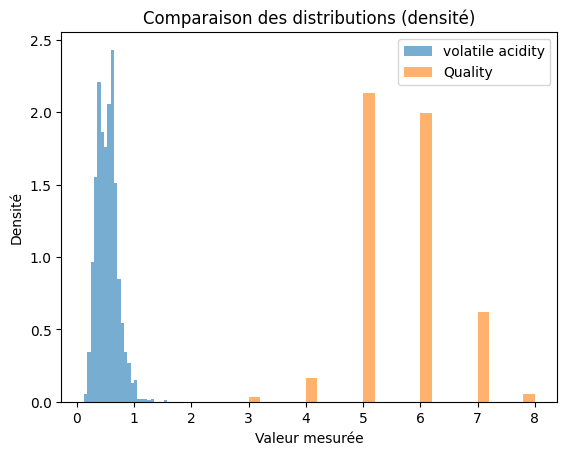

In [ ]:
plt.hist(df["volatile acidity"], bins=25, density=True, alpha=0.6, label="volatile acidity")
plt.hist(df["Quality"], bins=25, density=True, alpha=0.6, label="Quality")

plt.xlabel("Valeur mesurée")
plt.ylabel("Densité")
plt.title("Comparaison des distributions (densité)")
plt.legend()
plt.show()

In [ ]:
# Statistiques
resume = pd.DataFrame({
    "Moyenne": [sA.mean(), sB.mean()],
    "Médiane": [sA.median(), sB.median()],
    "Écart-type": [sA.std(ddof=1), sB.std(ddof=1)],
    "Variance": [sA.var(ddof=1), sB.var(ddof=1)],
    "Q1": [sA.quantile(0.25), sB.quantile(0.25)],
    "Q3": [sA.quantile(0.75), sB.quantile(0.75)],
    "Min": [sA.min(), sB.min()],
    "Max": [sA.max(), sB.max()]
}, index=["volatile acidity", "Quality"])

resume

,Moyenne,Médiane,Écart-type,Variance,Q1,Q3,Min,Max
volatile acidity,0.527821,0.52,0.179060,0.032062,0.39,0.64,0.12,1.58
Quality,5.636023,6.00,0.807569,0.652168,5.00,6.00,3.00,8.00


/tmp/ipython-input-3540202943.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sA, sB], labels=["volatile acidity", "Quality"])


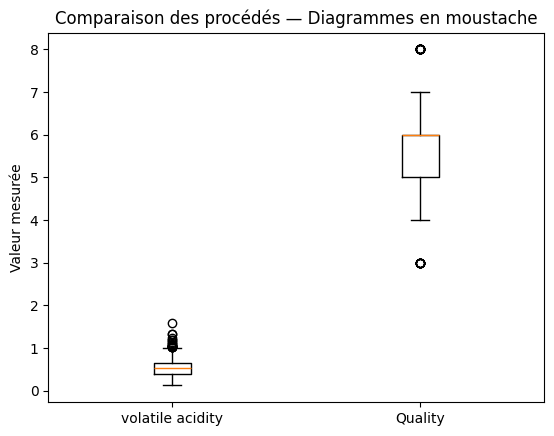

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([sA, sB], labels=["volatile acidity", "Quality"])
plt.ylabel("Valeur mesurée")
plt.title("Comparaison des procédés — Diagrammes en moustache")
plt.show()


/tmp/ipython-input-3540202943.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sA, sB], labels=["volatile acidity", "Quality"])


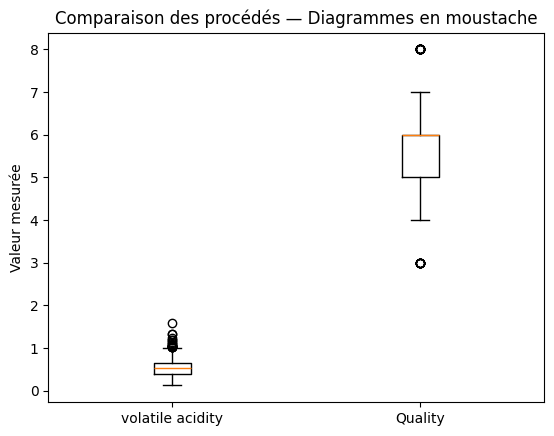

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([sA, sB], labels=["volatile acidity", "Quality"])
plt.ylabel("Valeur mesurée")
plt.title("Comparaison des procédés — Diagrammes en moustache")
plt.show()


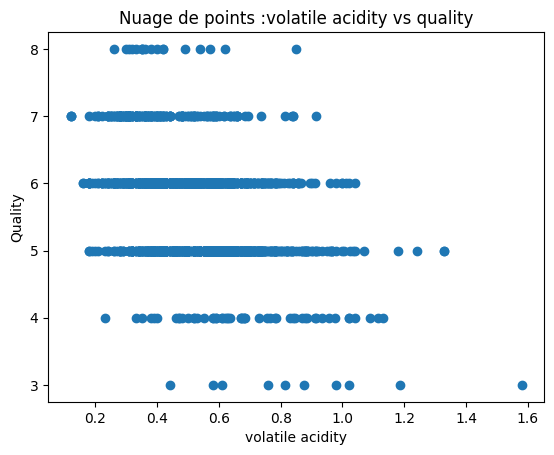

In [ ]:
#nuage de points
plt.scatter(df["volatile acidity"], df["Quality"])#déclaration des données en abscisse et ordonnée
plt.xlabel("volatile acidity") #ce qu'on veut afficher sous l'axe des abscisses
plt.ylabel("Quality") #ce qu'on veut afficher le long de l'axe des ordonnées
plt.title("Nuage de points :volatile acidity vs quality") #tittre du graphique
plt.show() #affichage du graphique


In [ ]:
cov = df.cov() #calcul de la covariance
corr = df.corr() #calcul du coefficient de corrélation linéaire

cov, corr

(                  volatile acidity   Quality
 volatile acidity          0.032062 -0.056476
 Quality                  -0.056476  0.652168,
                   volatile acidity   Quality
 volatile acidity          1.000000 -0.390558
 Quality                  -0.390558  1.000000)

Nombre de paires avec |corr| >= seuil : 0


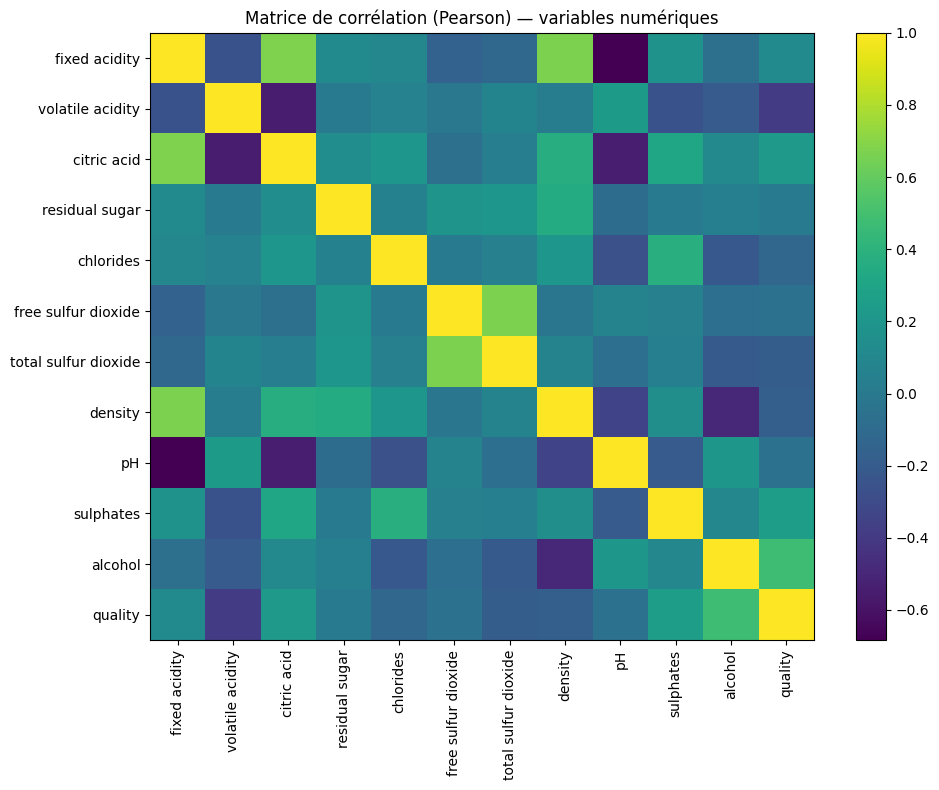

In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

def load_csv_safely(path: str, sep: str | None = None, decimal: str | None = None) -> pd.DataFrame:
    """
    Charge un CSV en gérant les cas fréquents :
    - séparateur ; (Excel FR) ou ,
    - décimales avec virgule
    """
    read_kwargs = {}
    if sep is not None:
        read_kwargs["sep"] = sep
    if decimal is not None:
        read_kwargs["decimal"] = decimal

    try:
        df = pd.read_csv(path, **read_kwargs)
        return df
    except Exception:
        # Tentative d'auto-détection du séparateur si non spécifié
        if sep is None:
            try:
                df = pd.read_csv(path, sep=None, engine="python", **{k:v for k,v in read_kwargs.items() if k!="sep"})
                return df
            except Exception as e2:
                raise RuntimeError(f"Impossible de lire le CSV. Essayez sep=';' et/ou decimal=','.\nDétail: {e2}") from e2
        raise

def correlations_all_pairs(
    df: pd.DataFrame,
    method: str = "pearson",
    min_abs_corr: float = 0.1,
    drop_na: bool = True,
    min_valid_pairs: int = 10,
    exclude_columns: list[str] | None = None
) -> pd.DataFrame:
    """
    Calcule les corrélations pour toutes les paires de colonnes numériques.
    Retourne un DataFrame trié par |corr| décroissant.
    """
    if exclude_columns is None:
        exclude_columns = []

    # Garder seulement les colonnes numériques
    num_df = df.select_dtypes(include=[np.number]).copy()

    # Option : exclure des colonnes (IDs, timestamps codés, etc.)
    for c in exclude_columns:
        if c in num_df.columns:
            num_df.drop(columns=[c], inplace=True)

    # Supprimer colonnes constantes (corrélation non définie)
    nunique = num_df.nunique(dropna=True)
    const_cols = nunique[nunique <= 1].index.tolist()
    if const_cols:
        num_df = num_df.drop(columns=const_cols)

    if num_df.shape[1] < 2:
        # Return an empty DataFrame with the expected columns if not enough columns to correlate
        return pd.DataFrame(columns=["col_1", "col_2", "corr", "abs_corr", "n_pairs"])

    cols = num_df.columns.tolist()
    results = []

    # Calcul paire par paire (plus robuste : gère NaN paire à paire)
    for a, b in itertools.combinations(cols, 2):
        x = num_df[a]
        y = num_df[b]
        if drop_na:
            mask = x.notna() & y.notna()
            x = x[mask]
            y = y[mask]

        if len(x) < min_valid_pairs:
            continue

        r = x.corr(y, method=method)
        if pd.isna(r):
            continue

        if abs(r) >= min_abs_corr:
            results.append({
                "col_1": a,
                "col_2": b,
                "corr": float(r),
                "abs_corr": float(abs(r)),
                "n_pairs": int(len(x))
            })

    if not results: # Handle the case where no correlations meet the threshold
        return pd.DataFrame(columns=["col_1", "col_2", "corr", "abs_corr", "n_pairs"])

    out = pd.DataFrame(results).sort_values("abs_corr", ascending=False).reset_index(drop=True)
    return out

def correlation_matrix(df: pd.DataFrame, method: str = "pearson", exclude_columns: list[str] | None = None) -> pd.DataFrame:
    if exclude_columns is None:
        exclude_columns = []
    num_df = df.select_dtypes(include=[np.number]).copy()
    for c in exclude_columns:
        if c in num_df.columns:
            num_df.drop(columns=[c], inplace=True)
    # Retirer constantes
    num_df = num_df.loc[:, num_df.nunique(dropna=True) > 1]
    return num_df.corr(method=method)

# === UTILISATION ===

# 1) Charger le CSV
# Exemple Colab : df = load_csv_safely("mon_fichier.csv", sep=";", decimal=",")
df = load_csv_safely("winequality-red.csv", sep=";")  # ou sep=";" / decimal="," si besoin

# 2) Calculer toutes les corrélations fortes (seuil à ajuster)
res = correlations_all_pairs(
    df,
    method="pearson",       # "pearson" (linéaire) ou "spearman" (monotone, plus robuste)
    min_abs_corr=0.7,       # seuil de "forte corrélation" (ex: 0.8)
    min_valid_pairs=10      # minimum de paires non-NaN pour accepter le calcul
)

# 3) Afficher les résultats
print(f"Nombre de paires avec |corr| >= seuil : {len(res)}")
res.head(30)  # Top 30 paires

# 4) Exporter le tableau des corrélations fortes (optionnel)
res.to_csv("correlations_fortes.csv", index=False)

# 5) (Optionnel) Carte de chaleur de la matrice de corrélation
corr_mat = correlation_matrix(df, method="pearson")
plt.figure(figsize=(10, 8))
plt.imshow(corr_mat, aspect="auto")
plt.xticks(range(len(corr_mat.columns)), corr_mat.columns, rotation=90)
plt.yticks(range(len(corr_mat.index)), corr_mat.index)
plt.title("Matrice de corrélation (Pearson) — variables numériques")
plt.colorbar()
plt.tight_layout()
plt.show()